In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint
from tqdm import tqdm
import torch
import torch.nn as nn
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from src.cstr import *
from src.machinelearning import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
df = generate_training_data(samples=10000, return_df=True)
X = df[['w1', 'Cb']].values
y = df['Cb_next'].values

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:00<00:00, 256139.14it/s]


In [16]:
input_dim = X.shape[1]
output_dim = 1

model = NeuralNet(input_dim,output_dim).to(device)
model = train_nn(model, X, y, 20000)

Epoch [1000/20000], Loss: 0.1148
Epoch [2000/20000], Loss: 0.1083
Epoch [3000/20000], Loss: 0.1038
Epoch [4000/20000], Loss: 0.1004
Epoch [5000/20000], Loss: 0.0969
Epoch [6000/20000], Loss: 0.0916
Epoch [7000/20000], Loss: 0.0826
Epoch [8000/20000], Loss: 0.0640
Epoch [9000/20000], Loss: 0.0303
Epoch [10000/20000], Loss: 0.0174
Epoch [11000/20000], Loss: 0.0153
Epoch [12000/20000], Loss: 0.0138
Epoch [13000/20000], Loss: 0.0126
Epoch [14000/20000], Loss: 0.0117
Epoch [15000/20000], Loss: 0.0101
Epoch [16000/20000], Loss: 0.0082
Epoch [17000/20000], Loss: 0.0069
Epoch [18000/20000], Loss: 0.0060
Epoch [19000/20000], Loss: 0.0055
Epoch [20000/20000], Loss: 0.0052


In [17]:
# model = SVR(C=10).fit(X, y)

In [18]:
Cb_ref = np.array([20.9 if t < 20 else 21.0 if t < 40 else 20.5 for t in range(L)])

Cb_res, w1_res = simulation(model, Cb_ref)

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:10<00:00,  5.51it/s]


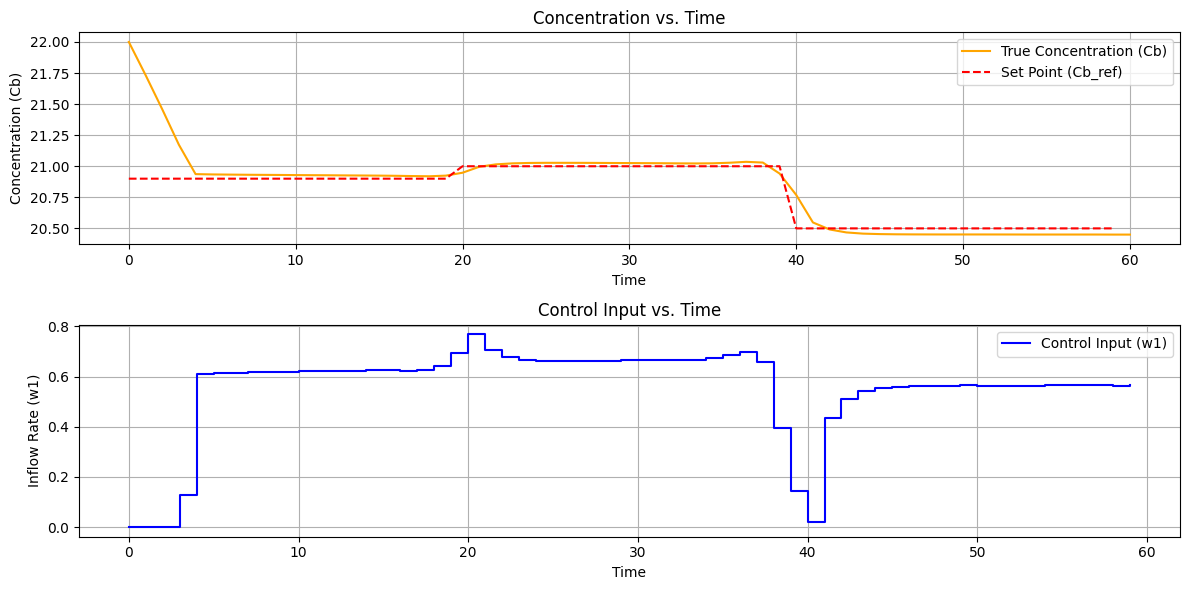

In [19]:
plot_results(Cb_res, Cb_ref, w1_res)

In [23]:
from scipy.integrate import odeint
from scipy.interpolate import interp1d

# --- Real System Dynamics --- #
def system_of_odes(t, y, w2):
    h, Cb = y
    w1 = w1_func(t)  # Get w1 at time t using interpolation
    dh_dt = w1 + w2 - 0.2 * np.sqrt(h)
    dCb_dt = ((Cb1 - Cb) * w1 / h + (Cb2 - Cb) * w2 / h - k1 * Cb / (1 + k2 * Cb)**2)
    return [dh_dt, dCb_dt]

# Make negative w1_res zero
t_points = np.arange(0, L, dt)  
w1_func = interp1d(t_points, w1_res, kind='linear', fill_value="extrapolate")

/tmp/ipykernel_1352/3747540106.py:8: RuntimeWarning: invalid value encountered in sqrt
  dh_dt = w1 + w2 - 0.2 * np.sqrt(h)


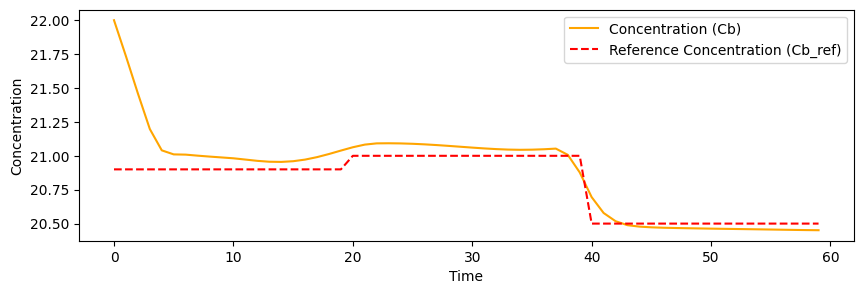

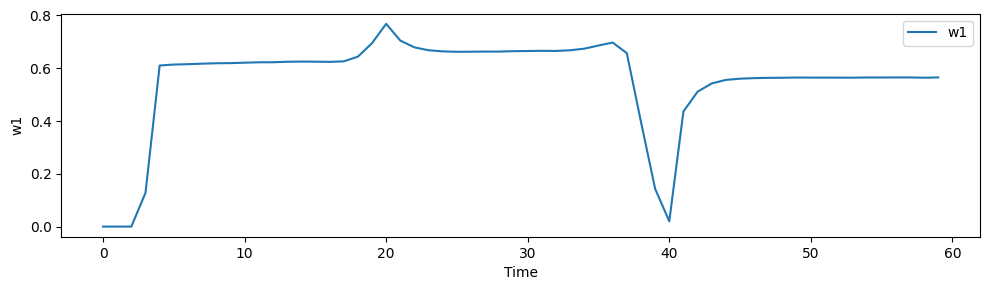

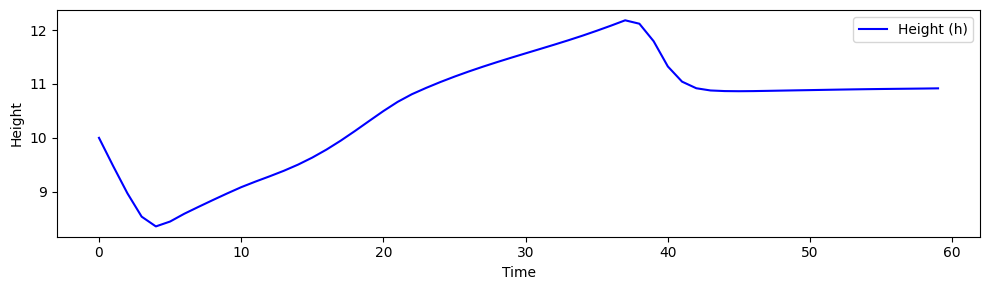

In [26]:
# Time span for the solution
t_span = (0, L)  # From t=0 to t=L
y0 = [h0, Cb0]  # Initial
sol = solve_ivp(system_of_odes, t_span, y0, args=(w2,), 
                method='RK45', t_eval=np.arange(0, L, dt))

# Extract the solution
t = sol.t
h = sol.y[0]
Cb = sol.y[1]

# Plot the results
plt.figure(figsize=(10, 3))
plt.plot(t, Cb, label='Concentration (Cb)', color='orange')
plt.plot(t, Cb_ref, label='Reference Concentration (Cb_ref)', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()

# Plot the input w1
plt.figure(figsize=(10, 3))
plt.plot(t, w1_func(t), label='w1')
plt.xlabel('Time')
plt.ylabel('w1')    
plt.legend()

plt.tight_layout()
plt.show()

# Plot h 
plt.figure(figsize=(10, 3))
plt.plot(t, h, label='Height (h)', color='blue')
plt.xlabel('Time')
plt.ylabel('Height')
plt.legend()
plt.tight_layout()
plt.show()